## Quadrature

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
from scipy.integrate import quad, fixed_quad
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")
import sympy as sp
from IPython.display import HTML
from matplotlib import animation
%matplotlib inline

# Don't tinker, or do
#%matplotlib nbagg
# from matplotlib import rcParams
#rcParams['font.family']='sans-serif' 
#rcParams('font', serif='Helvetica Neue') 
# rcParams['text.usetex']= True 
#rcParams.update({'font.size': 22})

## Numerical integration schemes
Integration is a fundamental operation in calculus, and involves finding the area under a certain curve (geometrically). As and when you were first introduced to integration, you realized that certain functions cannot be analytically integrated (the reverse is not true however---differentiation of functions was more natural!). But the definite integral of such functions (indefinite integrals are important, but not central in engineering) can at least be estimated numerically. We look at some schemes/algorithms to do such an estimation. The problem we deal with is then to approximate
$$  \int_{a}^{b} f(x) dx  \approx \sum_{i=1}^{n} \omega_i f(x_i) $$
given an integrable function $f : [a,b] \to \mathbb{R}$ with *nodes* ($x_i$) and *weights* ($\omega_i$). Schemes that we will be discussing involve careful choices of these nodes and weights. 

To get started, let us define a class that helps us implement any quadrature rule easily.

In [2]:
class SpatialIntegrator(object):
    """ Class for wrapping a quadrature scheme with other goodies
    """
    def __init__(self, i_a, i_b, i_h):
        """ Initialize the integrator
        """
        # What forcing function are we using?
        self.forcing = None

        # What integration algorithm are we using?
        self.integrator = None

        self.a = i_a
        self.b = i_b
        self.h = i_h
        self.nsteps = int((i_b - i_a)/i_h)

    def set_forcing_function(self, t_func):
        """ Set forcing function (or) integrand to be used 
        """
        if type(t_func) is not str:
            try:
                # If not string, try and evaluate the function
                t_func(0.0)
                # If the function works, set this function as forcing
                self.forcing = t_func
            except:
                raise RuntimeError('Provided function cannot be evaluated')
        
    def analytic(self):
        """  For testing convergence, defined as a special function """
        if self.forcing.__name__ == "composite_function":
            analytical_integral = (self.forcing(self.b)[1] - self.forcing(self.a)[1])
        else:
            def temp_func(x):
                return self.forcing(x)[0]
            analytical_integral, _ = quad(temp_func, self.a, self.b)
        return analytical_integral
            
    def integrate_using(self, integrator, renderer):
        """  Integrates the function and spits out the relative error
        """
        self.integrator = integrator.__name__
        all_starts = np.linspace(self.a, self.b - self.h, self.nsteps)
        all_ends = all_starts + self.h                
        integral, start_end_values = integrator(self.forcing, all_starts, all_ends)
        integral = np.sum(integral)
        
        analytical_integral = self.analytic()
        print("Integral is {:20.16f}, Analytical integral is {:20.16f}, Relative error is {:20.16f}".format(integral, analytical_integral, np.abs(integral/analytical_integral - 1)))
        # Pass as (2xn) arrays. While reshaping do T to get (nx2) arrays
        self.draw(renderer, start_end_values)
        return np.abs(integral - analytical_integral)/np.abs(analytical_integral)

    def draw(self, renderer, st_end_vals):
        """ Draw the matplotlib canvas with the portrait we want
        """
        # If there is a timestepper, then there is numerical data
        # Plot them
        fine_mesh = np.linspace(self.a, self.b, 1001)
        renderer.plot(fine_mesh, self.forcing(fine_mesh)[0], 'r-', label=r'$f(x)$')

        # This step interleaves data present in 0,2,4,6... by transposing
        # them and then reshaping
        all_x_values = st_end_vals[0::2].T
        all_x_values = all_x_values.reshape(-1,)

        all_y_values = st_end_vals[1::2].T
        all_y_values = all_y_values.reshape(-1,)
        
        renderer.plot(all_x_values, all_y_values, 'k--')
        renderer.fill_between(all_x_values, all_y_values, alpha=0.2)
        renderer.legend()
        renderer.set_xlabel(r'$x$')
        renderer.set_ylabel(r'$y$')
        renderer.set_title(r'${}$'.format(self.integrator))
#         renderer.set_aspect('equal')


## Quadrature

A variety of rules for quadratures exist, and we are going to look at three simple ones : (a) Midpoint (b) Trapezoidal and (c) Simpson rules, although others (Clenshaw--Curtis, Gaussian quadrature) will be discussed on the way. We will attempt to compare these methods in terms of their ease (in understanding/implementation), order of accuracy (in comparison to the discretization $h$) and function evaluations for each step $h$.

## What do these rules do?
They approximate the area under the curve in a smart way---using local polynomials (in the case of interpolatory quadrature), you approximate the curve and integrate these polynomials instead. This approximation is not arbitrary, it represents a local Taylor series expansion. We'll first look at some schemes and what local polynomials they represent. 

In [3]:
def trapezoidal(func, lhs, rhs):
    """Does quadrature for one panel using the trapezoidal
    rule
    
    Parameters
    ----------
    func : ufunc
        A function, f, that takes one argument and
        returns the function value and exact integral
        as a tuple
    lhs : float/array-like
        The lower evaluation limit of the definite integral
    rhs : float/array-like
        The upper evalutation limit of the definite integral

    Returns
    -------
    integral : float/array-like
        Approximation of the integral using quadrature
    pts : np.array
        Points and values at which the local polynomials
        are drawn, specified as (x_1,fx_1,x_2,fx_2,...)
    """
    tmp1, tmp2 = func(lhs)[0], func(rhs)[0]
    return 0.5*(rhs-lhs)*(tmp1 + tmp2), np.array([lhs, tmp1, rhs, tmp2])

In [4]:
def midpoint(func, lhs, rhs):
    """Does quadrature for one panel using the midpoint
    rule
    
    Parameters
    ----------
    func : ufunc
        A function, f, that takes one argument and
        returns the function value and exact integral
        as a tuple
    lhs : float/array-like
        The lower evaluation limit of the definite integral
    rhs : float/array-like
        The upper evalutation limit of the definite integral

    Returns
    -------
    integral : float/array-like
        Approximation of the integral using quadrature
    pts : np.array
        Points and values at which the local polynomials
        are drawn, specified as (x_1,fx_1,x_2,fx_2,...)
    """
    tmp = func(0.5*(lhs+rhs))[0]
    return (rhs-lhs)*tmp, np.array([lhs, tmp, rhs, tmp])

In [5]:
def simpson(func, lhs, rhs):
    """Does quadrature for one panel using the Simpson
    rule
    
    Parameters
    ----------
    func : ufunc
        A function, f, that takes one argument and
        returns the function value and exact integral
        as a tuple
    lhs : float/array-like
        The lower evaluation limit of the definite integral
    rhs : float/array-like
        The upper evalutation limit of the definite integral

    Returns
    -------
    integral : float/array-like
        Approximation of the integral using quadrature
    pts : np.array
        Points and values at which the local polynomials
        are drawn, specified as (x_1,fx_1,x_2,fx_2,...)
    """
    tmp1, tmp2, tmp3 = func(lhs)[0], func(rhs)[0], func(0.5*(lhs+rhs))[0]
    return (rhs-lhs)/6. * (tmp1+tmp2+4*tmp3), np.array([lhs, tmp1, 0.5*(lhs+rhs), tmp3, rhs, tmp2])

## Testing quadrature?
Let's test these rules out between $[a,b]$ for simple polynomial (constant, linear, quadratic and cubic) curves and draw inferences from them (What's the error and so on...)

In [6]:
# Bounds of integration
a = 0
b = 1
h = (b-a)

# Define function to be integrated and
# its integral
def test_func(x):
#     # Constant
#     return 1. + 0.*x, 0. + 1.*x

#     # Linear
#     return 0. + 1.*x, 0. + 0.5*x**2

#     # Quadratic
#     return 0. + 1.*x**2, 0. + x**3/3.

    # Cubic
    return 0. + 1.*x**3, 0. + x**4/4.

Integral is   0.2500000000000000, Analytical integral is   0.2500000000000000, Relative error is   0.0000000000000000


0.0

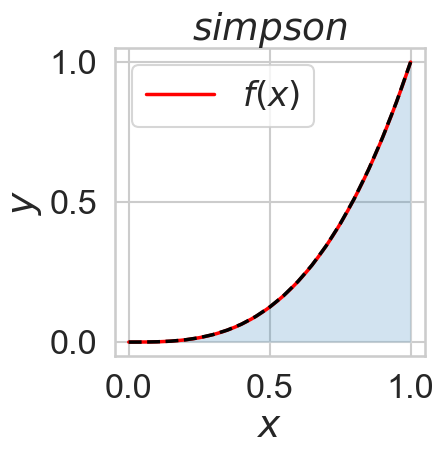

In [22]:
fig, ax = plt.subplots(1,1, figsize=(4, 4))
si = SpatialIntegrator(a, b, h)
si.set_forcing_function(test_func)

# Try out different rules below
# si.integrate_using(midpoint, ax)
# si.integrate_using(trapezoidal, ax)
si.integrate_using(simpson, ax)

### Things to observe
- What local polynomial orders do they fit?
- Is there a relation between the errors of the midpoint and trapezoidal quadrature rule?
- How do they perform for functions that are more complicated (say, a cubic)?

## Composite quadrature
We saw that if the function is not simple, quadrature struggles to give us approximations that are close. When faced with this situtation, we do what we do best---throw in more points and hope for the best. This has a name---"Composite quadrature", which fits the curve into many small piecewise polynomials and integrates them instead. We can also rigorously show the error bounds for composite rules too. Let's do that now.  

In [8]:
# Bounds of integration
a = 0
b = 1

# All the change comes in this part only. 
# Instead of simple interval, we pass many
# such intervals to the quadrature rule
# and sum them up
h = (b-a)/10

# Define not so simple function to be integrated
def composite_function(x):
#     return np.exp(2*x), 0.5*np.exp(2*x)

#    return np.exp(x)*(1-np.cos(2.*np.pi*x)), np.exp(x)*(1. + 4.*np.pi**2 - np.cos(2.*np.pi*x) - 2.*np.pi*np.sin(2.*np.pi*x))/(1. + 4.*np.pi**2)

#    return np.sqrt(1-x**2), 0.5*( x * np.sqrt(1-x**2) + np.arcsin(x))

#     return np.log(2. + np.cos(2.*np.pi*x)), 2*x

     return 1. + np.cos(2.*np.pi*x), x + np.sin(2.*np.pi*x)/(2.*np.pi)

Integral is   1.0000000000000000, Analytical integral is   1.0000000000000000, Relative error is   0.0000000000000000


0.0

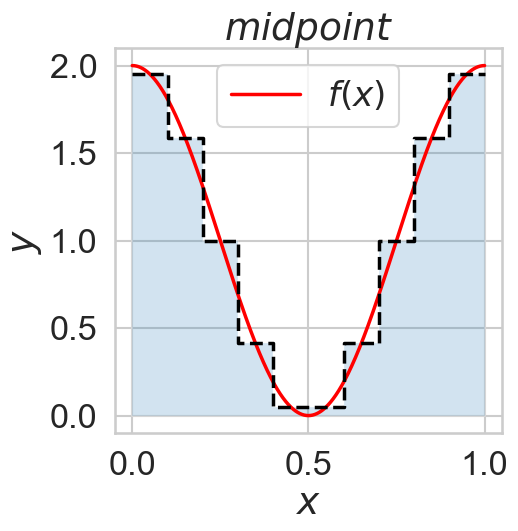

In [9]:
fig, ax = plt.subplots(1,1, figsize=(5, 5))
si = SpatialIntegrator(a, b, h)
si.set_forcing_function(composite_function)

# Try out different rules below
si.integrate_using(midpoint, ax)
# si.integrate_using(trapezoidal, ax)
# si.integrate_using(simpson, ax)

## Order of accuracy of composite quadrature rules
What's **order** of accuracy? Order of accuracy quantifies the rate of convergence of a numerical approximation of a integral to the exact integral.
The numerical solution ${u}$ is said to be $n^{\text{th}}$-order accurate if the error, $e(h):=\lvert\tilde{{u}}-{u} \rvert$ is proportional to the discretization-size $ h $, to the $n^{\text{th}}$ power. That is

$$ e(h)=\lvert\tilde{{u}}-{u} \rvert\leq C(h)^{n} $$

Details of this are given in the slides. Here, we focus on integrating a simple function (which has a non-negligible contribution from H.O.T in the Taylor series ) and figure out the order of convergence. The model problem that we deal with is

$$ \int_{0}^{1} e^{2x} dx $$
which as we know has the analytical solution $ \tilde{y} = \frac{e^{2}}{2} $, and so error can be calculated.

### Gaussian quadrature
Before doing tests for convergence, let us also implement Gaussian quadrature using `scipy.integrate.fixed_quad`

In [10]:
def gauss(func, lhs, rhs):
    """Does quadrature for one panel using the Gaussian rule
    
    Parameters
    ----------
    func : ufunc
        A function, f, that takes one argument and
        returns the function value and exact integral
        as a tuple
    lhs : float/array-like
        The lower evaluation limit of the definite integral
    rhs : float/array-like
        The upper evalutation limit of the definite integral

    Returns
    -------
    integral : float/array-like
        Approximation of the integral using quadrature
    pts : np.array
        Points and values at which the local polynomials
        are drawn, specified as (x_1,fx_1,x_2,fx_2,...)
    """
    def temp_func(x):
        return func(x)[0]
    
    quad_sum = 0.0
    for i in range(lhs.shape[0]):
        quad_sum += fixed_quad(temp_func, lhs[i], rhs[i], n=3)[0] 
    return quad_sum, np.array([lhs, 0.0*lhs, rhs, 0.0*rhs])

In [11]:
# Bounds of integration
a = 0
b = 1

# All functions that you coded up
impl_list = [midpoint, trapezoidal, simpson, gauss]

# Time steps and associated errors from 25*1 to 25*12
h_steps = np.arange(1, 12, dtype=np.int16)
errors_list = [[None for i in h_steps] for impl in impl_list]

# Run simulations and collect errors
for i_impl, impl in enumerate(impl_list):
    for i_step, step in enumerate(h_steps):
        new_h = (b-a)/(25*(step))
        si = SpatialIntegrator(a, b, new_h)
        si.set_forcing_function(composite_function)
        errors_list[i_impl][i_step] = si.integrate_using(impl, ax)

Integral is   1.0000000000000004, Analytical integral is   1.0000000000000000, Relative error is   0.0000000000000004
Integral is   1.0000000000000007, Analytical integral is   1.0000000000000000, Relative error is   0.0000000000000007
Integral is   0.9999999999999990, Analytical integral is   1.0000000000000000, Relative error is   0.0000000000000010
Integral is   1.0000000000000004, Analytical integral is   1.0000000000000000, Relative error is   0.0000000000000004
Integral is   1.0000000000000007, Analytical integral is   1.0000000000000000, Relative error is   0.0000000000000007
Integral is   1.0000000000000027, Analytical integral is   1.0000000000000000, Relative error is   0.0000000000000027
Integral is   0.9999999999999969, Analytical integral is   1.0000000000000000, Relative error is   0.0000000000000031
Integral is   1.0000000000000009, Analytical integral is   1.0000000000000000, Relative error is   0.0000000000000009
Integral is   1.0000000000000027, Analytical integral is

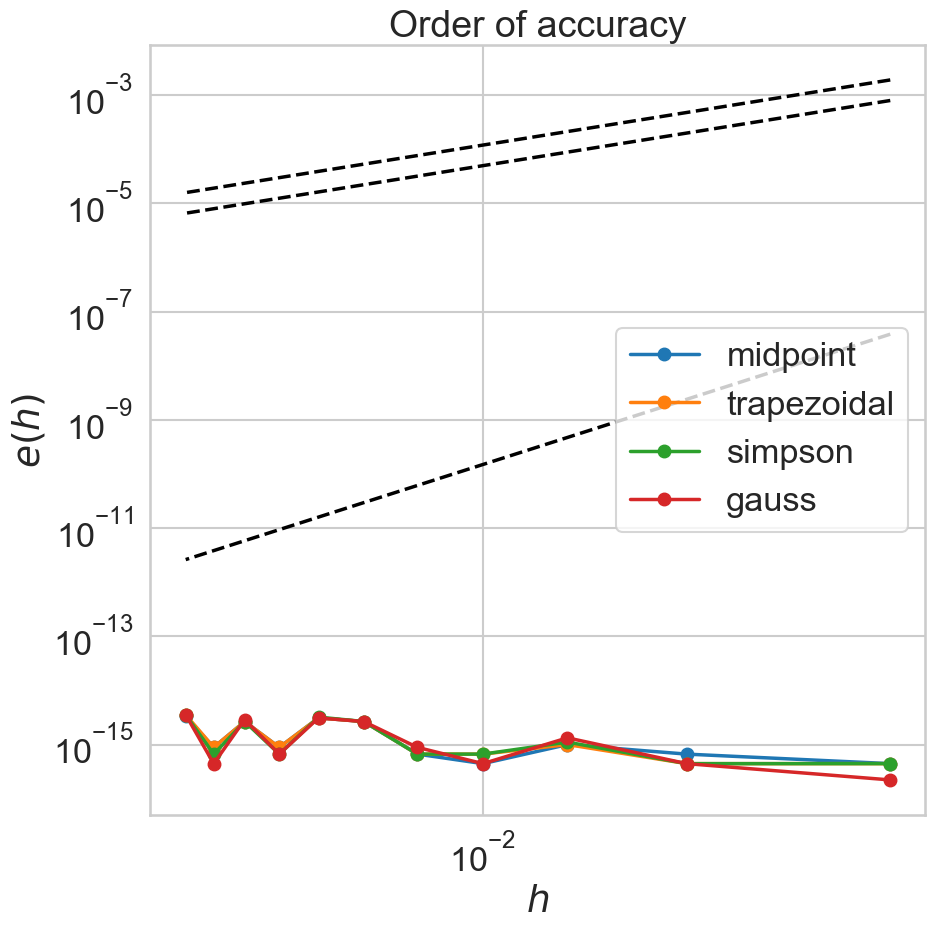

In [12]:
# Draw error plots in a log-log plot
fig, ax = plt.subplots(1,1, figsize=(10, 10))

# x axis is time, y axis is error
for i_impl, impl in enumerate(impl_list):
    ax.plot((b-a)/(25.*h_steps), errors_list[i_impl], 'o-', label=impl.__name__)

# Draw helpful slope lines to compare
x_ax = (b-a)/(25.*h_steps)
ax.plot(x_ax, 1.2 * x_ax**2, 'k--')
ax.plot(x_ax, 0.5 * x_ax**2, 'k--')
ax.plot(x_ax, 0.015 * x_ax**4, 'k--')  

# Make it readable
ax.set_xlabel(r'$h$')
ax.set_ylabel(r'$e(h)$')
ax.set_title('Order of accuracy')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
# fig.savefig('ooa.pdf')

### Things to observe
- What is the order of accuracy in the composite case?
- How does this compare to our error estimation (through Taylor series expansion) for non-composite and composite cases? 
- Is the error function dependent? (change functions and see). If so, why?

## Analysis of the functions above
Some further analysis is needed to explain the results above.

In [13]:
sp.x = sp.symbols('x')
# sp_expr = sp.exp(sp.x)*(1-sp.cos(2.*sp.pi*sp.x))
sp_expr = sp.sqrt(1-sp.x**2)

In [14]:
expr_list = []
max_derivative = 3
for i in range(max_derivative):
    new_expr = sp.diff(sp_expr, sp.x, i)
    expr_list.append(sp.lambdify(sp.x, new_expr, 'numpy'))

<lambdifygenerated-2>:2: RuntimeWarning: divide by zero encountered in true_divide
  return -x/sqrt(1 - x**2)
<lambdifygenerated-3>:2: RuntimeWarning: divide by zero encountered in true_divide
  return -(x**2/(1 - x**2) + 1)/sqrt(1 - x**2)


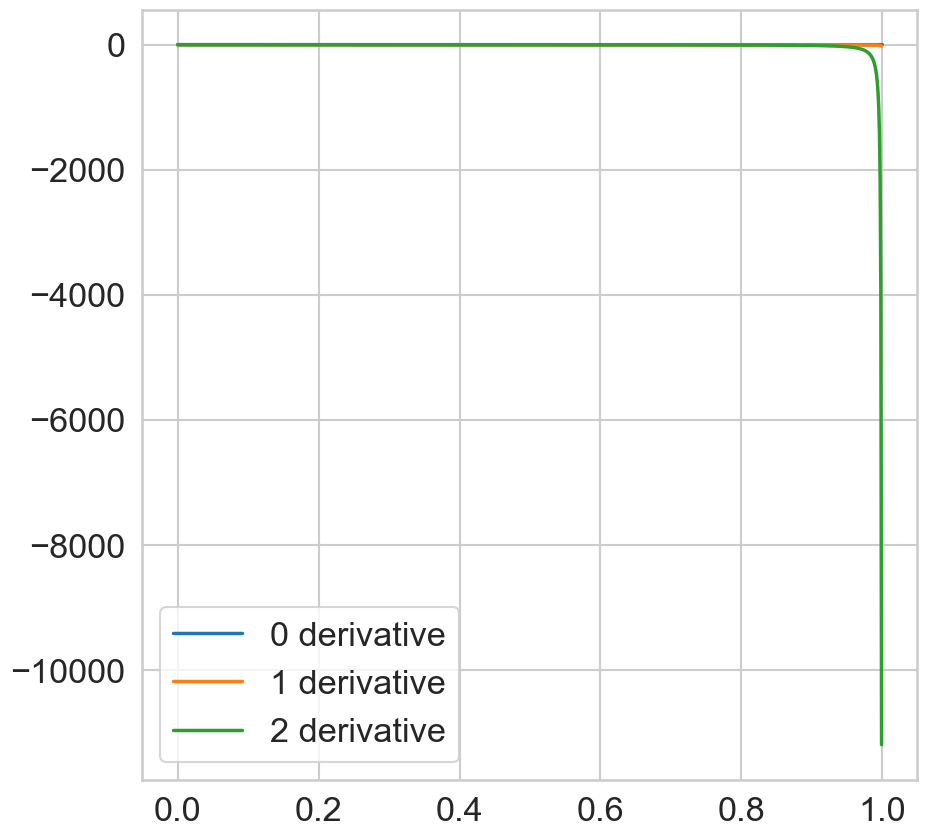

In [15]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
x = np.linspace(0.0, 1.0, 1001)
for i_expr, expr in enumerate(expr_list):
    ax.plot(x, expr(x), label=r'{} derivative'.format(i_expr))
ax.legend()